In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import docker
import matplotlib.pyplot as plt
import time

client = docker.from_env()

In [3]:
app_names = ['homecloud.app', 'ory.hydra', 'ory.kratos']
containers = []

for app_name in app_names:
    app_containers = client.containers.list(filters={'label': 'AppID=' + app_name})
    for container in app_containers:
        containers.append(container)

[container.name for container in containers]

['homecloud.app-homecloud', 'ory.hydra-hydra', 'ory.kratos-kratos']

In [4]:
import psutil

process = None
for proc in psutil.process_iter(['pid', 'name']):
    if proc.info['name'] == 'launcher':
        process = proc

process

psutil.Process(pid=7322, name='launcher', status='sleeping', started='12:34:55')

In [5]:
container_test = containers[0]
stream = container_test.stats(stream=True, decode=True)
next(stream)
stats = next(stream)
stream.close()

cpu_delta = stats['cpu_stats']['cpu_usage']['total_usage'] - stats['precpu_stats']['cpu_usage']['total_usage']
system_cpu_delta = stats['cpu_stats']['system_cpu_usage'] - stats['precpu_stats']['system_cpu_usage']


# len_cpu = len(stats['cpu_stats']['cpu_usage']['percpu_usage'])
# cpu_percent = (cpu_delta / system_cpu_delta) * len_cpu * 100.0

# cpu_percent

In [6]:
from collections import defaultdict
import threading
import psutil

samples = 100
interval = 2
start_time = time.time()

results = defaultdict(list)

def sample_process(process, t0):
    for i in range(samples):
        target_time = t0 + i * interval
        sleep_time = target_time - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)

        memory_usage = process.memory_info().rss
        cpu_percent = process.cpu_percent(interval=0.1)

        results[target_time].append({'process_name': process.name, 'timestamp': target_time, 'memory_usage': memory_usage, 'cpu_percent': cpu_percent})
        print(f"Process: {process.name}, Memory Usage: {memory_usage}, CPU Percent: {cpu_percent}")

def sample_container(container, t0):
    name = container.name
    stream = container.stats(stream=True, decode=True)
    
    # Skip the first stats to ensure precpu stats are populated
    next(stream)

    for i in range(samples):
        target_time = t0 + i * interval
        sleep_time = target_time - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)

        stats = next(stream)
        memory_usage = stats['memory_stats']['usage']
        cpu_delta = stats['cpu_stats']['cpu_usage']['total_usage'] - stats['precpu_stats']['cpu_usage']['total_usage']
        system_cpu_delta = stats['cpu_stats']['system_cpu_usage'] - stats['precpu_stats']['system_cpu_usage']
        len_cpu = psutil.cpu_count()
        cpu_percent = (cpu_delta / system_cpu_delta) * len_cpu * 100.0

        results[target_time].append({'container_name': name, 'timestamp': target_time, 'memory_usage': memory_usage, 'cpu_percent': cpu_percent})
        print(f"Container: {name}, Memory Usage: {memory_usage}, CPU Percent: {cpu_percent}") 

    stream.close()

t0 = time.time() + 1

threads = []

process_thread = threading.Thread(target=sample_process, args=(process, t0))
process_thread.start()
threads.append(process_thread)

for container in containers:
    t = threading.Thread(target=sample_container, args=(container, t0))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

Process: <bound method Process.name of psutil.Process(pid=7322, name='launcher', status='sleeping', started='12:34:55')>, Memory Usage: 16613376, CPU Percent: 0.0
Container: ory.hydra-hydra, Memory Usage: 14909440, CPU Percent: 0.0
Container: homecloud.app-homecloud, Memory Usage: 9355264, CPU Percent: 1.139
Container: ory.kratos-kratos, Memory Usage: 25067520, CPU Percent: 0.011829573934837093
Container: ory.hydra-hydra, Memory Usage: 14909440, CPU Percent: 0.0138
Container: homecloud.app-homecloud, Memory Usage: 9355264, CPU Percent: 1.6341999999999999
Container: ory.kratos-kratos, Memory Usage: 25067520, CPU Percent: 0.0
Process: <bound method Process.name of psutil.Process(pid=7322, name='launcher', status='sleeping', started='12:34:55')>, Memory Usage: 16613376, CPU Percent: 0.0
Container: homecloud.app-homecloud, Memory Usage: 9371648, CPU Percent: 1.6394014962593517Container: ory.kratos-kratos, Memory Usage: 25067520, CPU Percent: 0.0

Container: ory.hydra-hydra, Memory Usage: 1

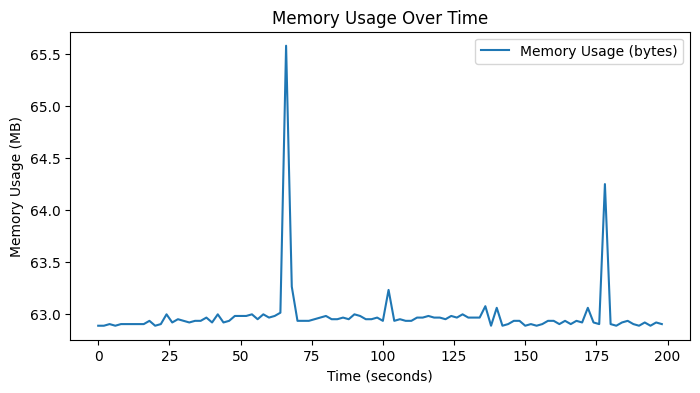

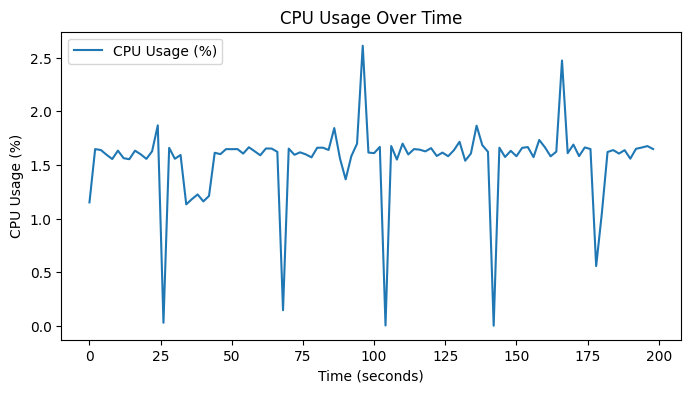

In [7]:
timestamps = []
memory_usages = []
cpu_usages = []

for timestamp, data in results.items():
    timestamps.append(timestamp - t0)
    memory_usage = 0
    cpu_usage = 0
    for entry in data:
        memory_usage += entry['memory_usage']
        cpu_usage += entry['cpu_percent']
    memory_usages.append(memory_usage)
    cpu_usages.append(cpu_usage)

memory_usages_mb = [usage / (1024 * 1024) for usage in memory_usages]

plt.figure(figsize=(8, 4))
plt.plot(timestamps, memory_usages_mb, label='Memory Usage (bytes)')
plt.title('Memory Usage Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(timestamps, cpu_usages, label='CPU Usage (%)')
plt.title('CPU Usage Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()